https://www.allesfitter.com/allesclass/retriving-data-and-models

In [6]:
import os

assert os.environ['CONDA_DEFAULT_ENV']=='ttv'

## all: space+ground

In [11]:
import os
import pickle
import gzip
from allesfitter import config

datadir = '../allesfitter/all_lc/'
config.init(datadir)
f = gzip.GzipFile(os.path.join(config.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results = pickle.load(f)
f.close()

results.keys(), #len(results)

Filling the Basement


allesfitter version
---------------------
v1.2.10
OrderedDict([('user-given:', ''),
             ('companions_phot', ['b']),
             ('companions_rv', []),
             ('inst_phot',
              ['muscat3_gp',
               'muscat3_rp',
               'lco1m_gp',
               'lco1m_V',
               'muscat3_ip',
               'keplercam_ip',
               'muscat3_zs',
               'lco0.4m_zs_2',
               'tess']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '40'),
             ('fast_fit', 'False'),
             ('fast_fit_width', '0.5'),
             ('secondary_eclipse', 'True'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch',
              ['muscat3_gp',
               'muscat3_rp',
               'lco1m_gp',
               'lco1m_V',
               'muscat3_ip',
               'keplercam_ip',
               'muscat3

(['niter',
  'ncall',
  'eff',
  'samples',
  'samples_id',
  'samples_batch',
  'samples_it',
  'samples_u',
  'samples_n',
  'logwt',
  'logl',
  'logvol',
  'logz',
  'batch_nlive',
  'batch_bounds',
  'blob',
  'logzerr',
  'information',
  'bound',
  'bound_iter',
  'samples_bound',
  'scale'],)

In [12]:
results['samples'].shape

(53369, 37)

In [13]:
from allesfitter import nested_sampling_output, general_output

posterior_samples = nested_sampling_output.draw_ns_posterior_samples(results)
posterior_samples.shape

(53369, 37)

In [14]:
config.BASEMENT.fitkeys, len(config.BASEMENT.fitkeys) 

(array(['b_rr', 'b_rsuma', 'b_cosi', 'b_epoch', 'b_period',
        'ln_err_flux_muscat3_gp', 'ln_err_flux_speculoos_gp',
        'ln_err_flux_lco1m_gp', 'ln_err_flux_lco1m_V',
        'ln_err_flux_muscat3_rp', 'ln_err_flux_muscat3_rp',
        'ln_err_flux_muscat3_ip', 'ln_err_flux_keplercam_ip',
        'ln_err_flux_muscat3_zs', 'ln_err_flux_trappist_Iz_1',
        'ln_err_flux_trappist_Iz_2', 'ln_err_flux_speculoos_zs',
        'ln_err_flux_lco0.4m_zs_2', 'ln_err_flux_tess',
        'baseline_gp_matern32_lnsigma_flux_muscat3_gp',
        'baseline_gp_matern32_lnrho_flux_muscat3_gp',
        'baseline_gp_matern32_lnsigma_flux_lco1m_gp',
        'baseline_gp_matern32_lnrho_flux_lco1m_gp',
        'baseline_gp_matern32_lnsigma_flux_lco1m_V',
        'baseline_gp_matern32_lnrho_flux_lco1m_V',
        'baseline_gp_matern32_lnsigma_flux_muscat3_rp',
        'baseline_gp_matern32_lnrho_flux_muscat3_rp',
        'baseline_gp_matern32_lnsigma_flux_muscat3_ip',
        'baseline_gp_matern32_l

In [15]:
posterior_params = nested_sampling_output.draw_ns_posterior_samples(results, as_type='dic') # all weighted posterior_samples
posterior_params_median, posterior_params_ll, posterior_params_ul = general_output.get_params_from_samples(posterior_samples)

In [16]:
import allesfitter
import numpy as np

af = allesfitter.allesclass(datadir)

Filling the Basement

OrderedDict([('user-given:', ''),
             ('companions_phot', ['b']),
             ('companions_rv', []),
             ('inst_phot',
              ['muscat3_gp',
               'muscat3_rp',
               'lco1m_gp',
               'lco1m_V',
               'muscat3_ip',
               'keplercam_ip',
               'muscat3_zs',
               'lco0.4m_zs_2',
               'tess']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '40'),
             ('fast_fit', 'False'),
             ('fast_fit_width', '0.5'),
             ('secondary_eclipse', 'True'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch',
              ['muscat3_gp',
               'muscat3_rp',
               'lco1m_gp',
               'lco1m_V',
               'muscat3_ip',
               'keplercam_ip',
               'muscat3_zs',
               'lco0.4m_zs_2',
              

In [17]:
instruments = list(config.BASEMENT.fulldata.keys())
instruments

['muscat3_gp',
 'muscat3_rp',
 'lco1m_gp',
 'lco1m_V',
 'muscat3_ip',
 'keplercam_ip',
 'muscat3_zs',
 'lco0.4m_zs_2',
 'tess']

In [21]:
# inst_names = ['$TESS$', '$Spitzer$', 'LCO u\'', 'LCO i\'', 'LCO g\'', 'NGTS', 'KELT']
inst_names = ['MuSCAT3 $g\'$', 'MuSCAT3 $r\'$', 'MuSCAT3 $i\'$', 'MuSCAT3 $z_s$', 'LCO-1m V', 'Keplercam $i\'$', 'LCO-1m g\'', 'LCO $z_s$', '$TESS$']

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'muscat3_gp, companion b'}, xlabel='$\\mathrm{ T - T_0 \\ (h) }$', ylabel='Relative Flux - Baseline'>)

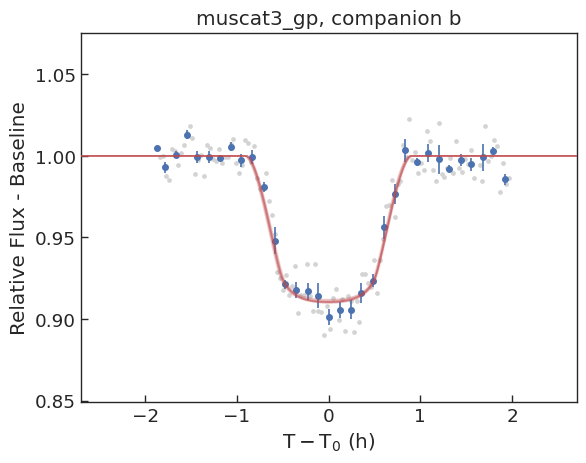

In [19]:
#'full' / 'phase' / 'phasezoom'
i = 'muscat3_gp'
af.plot(i, 'b', style='phasezoom')

Text(0.5, 0.05, 'Mid-transit (Hours)')

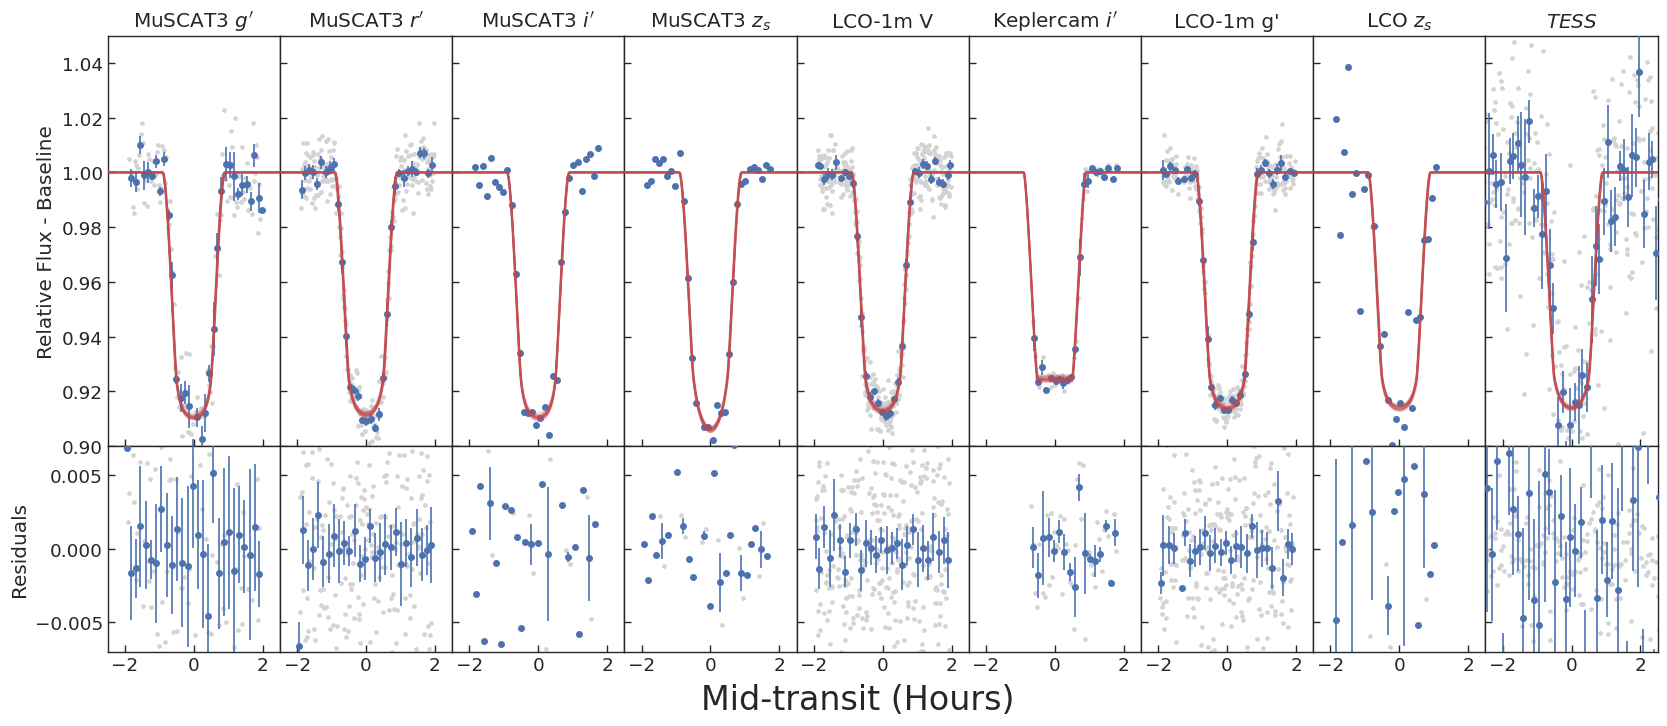

In [23]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.9,1.05]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=50
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', mode='initial_guess', force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

In [26]:
from aesthetic.plot import savefig

savefig(fig, '../figures/all_lc.pdf', writepdf=False)

2024-02-24T15:27:12.614389: made ../figures/all_lc.pdf


Text(0.5, 0.05, 'Mid-transit (Hours)')

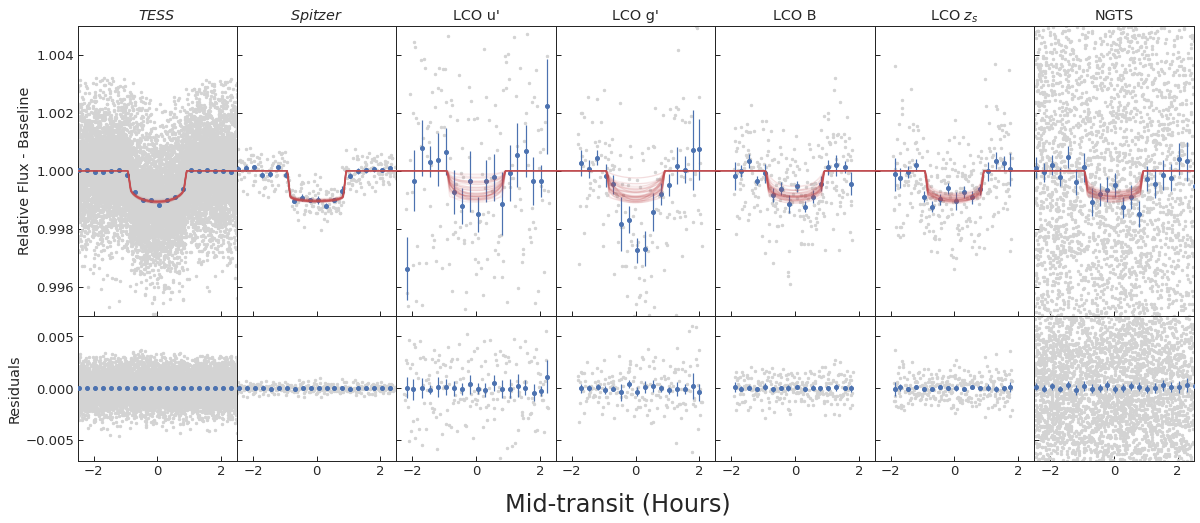

In [15]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.995,1.005]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=50
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', mode='initial_guess', force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

Text(0.5, 0.05, 'Mid-transit (Hours)')

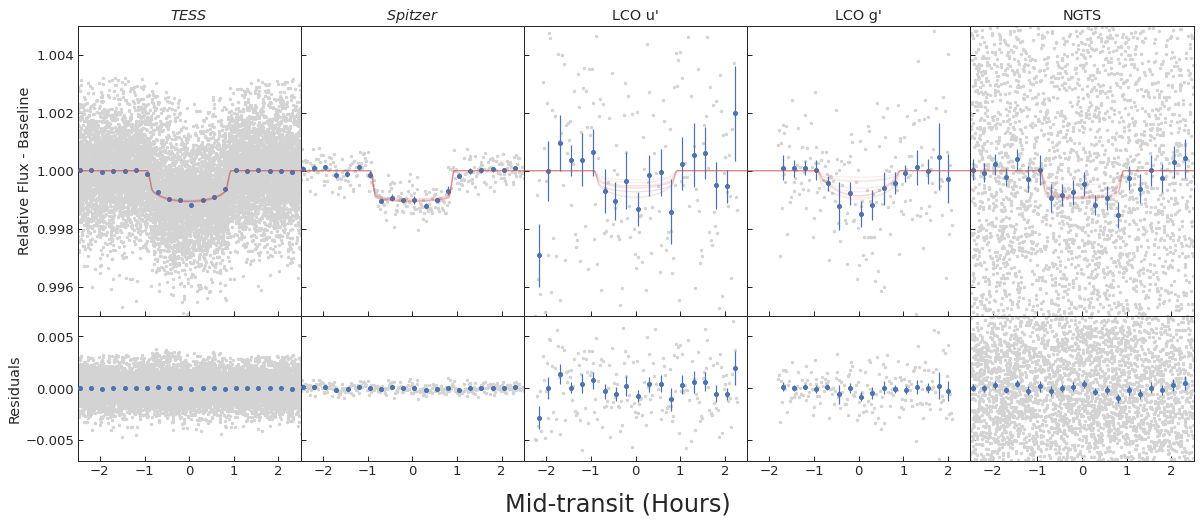

In [16]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.995,1.005]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=10
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', Nsamples=Nsamples, force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

In [16]:
fig.savefig('../figures/lcs_all.png', bbox_inches='tight')

## derived params

In [3]:
import flammkuchen as dd

df = dd.load('../data/phot/allesfit_transit_results.h5')

### vsini

In [44]:
import numpy as np

minerva = pd.read_csv('../data/spec/minerva_rv.txt', delim_whitespace=True, comment='#')
vsini_minerva = minerva.prelimVsini
np.median(vsini_minerva), np.std(vsini_minerva)

(8.266330968467578, 0.029182432807475175)

In [45]:
np.median(samples['radius']), np.percentile(samples['radius'], [16,84])

(0.7765445281930545, array([0.76750278, 0.78693514]))

In [35]:
import astropy.units as u

Rs = samples['radius']*u.Rsun.to(u.km)
Prot = 4.4*u.day.to(u.second)
inc = np.deg2rad(np.random.choice(df['joint']['posterior_samples']['inc'], len(Rs)))
vsini2 = 2*np.pi*Rs/Prot*np.sin(inc)
np.nanmedian(vsini2), np.nanstd(vsini2)

(8.919112045212618, 0.11256350344665209)

In [47]:
vsini_chiron = np.random.normal(3.41,0.85,size=len(Rs))
P=(2*np.pi*Rs*np.sin(inc))/vsini_minerva#vsini_chiron
np.nanmedian(P*u.second.to(u.day))

4.823044649399611

### Teq

In [51]:
Rs = samples['radius']
Teff = samples['Teff']
aRs = np.random.choice(df_samples['aRs'], len(Rs))
Teq_samples = (Teff * np.sqrt(Rs / (2 * aRs)))
Teq_samples.median(), Teq_samples.std()

(894.7508435020263, 35.561223309650245)

In [16]:
np.median(af.posterior_params['host_ldc_q1_tess']), np.std(af.posterior_params['host_ldc_q2_tess'] )

(0.3059200799974964, 0.3864129038122437)

In [17]:
np.median(af.posterior_params['host_ldc_q1_spitzer']), np.std(af.posterior_params['host_ldc_q2_spitzer'] )

(-1.0281288889461961, 0.8584369661127428)

## custom plots

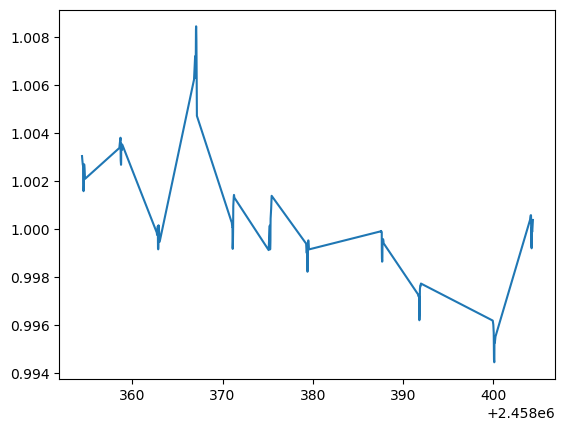

In [41]:
inst = 'tess'
t = af.data[inst]['time']
f = af.data[inst]['flux']
# pl.plot(t,f)
b = af.get_posterior_median_baseline(inst, 'flux')
m = af.get_posterior_median_model(inst, 'flux')
pl.plot(t,m+b)

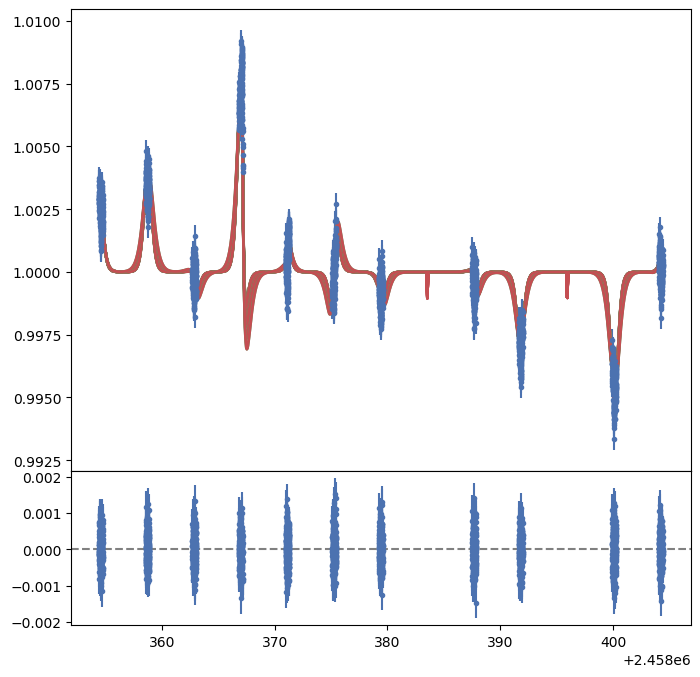

In [42]:
#::: settings
inst = 'tess'
key = 'flux'

#::: load the time, flux, and flux_err
time = af.data[inst]['time']
flux = af.data[inst][key]
flux_err = af.data[inst]['err_scales_'+key] * af.posterior_params_median['err_'+key+'_'+inst]

#::: set up the figure
fig, axes = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

#::: top panel: plot the data and 20 curves from random posterior samples (evaluated on a fine time grid)
ax = axes[0]
ax.errorbar(time, flux, flux_err, fmt='b.')
for i in range(20):
    time_fine = np.linspace(time[0], time[-1], 1000)
    model_fine, baseline_fine, _ = af.get_one_posterior_curve_set(inst, key, xx=time_fine)
    ax.plot(time_fine, 1.+baseline_fine, 'g-', lw=2)
    ax.plot(time_fine, model_fine+baseline_fine, 'r-', lw=2)

#::: bottom panel: plot the residuals;
#::: for that, subtract the "posterior median model" and "posterior median baseline" from the data (evaluated on the time stamps of the data)
ax = axes[1]
baseline = af.get_posterior_median_baseline(inst, key)
model = af.get_posterior_median_model(inst, key)
ax.errorbar(time, flux-(model+baseline), flux_err, fmt='b.')
ax.axhline(0, color='grey', linestyle='--')

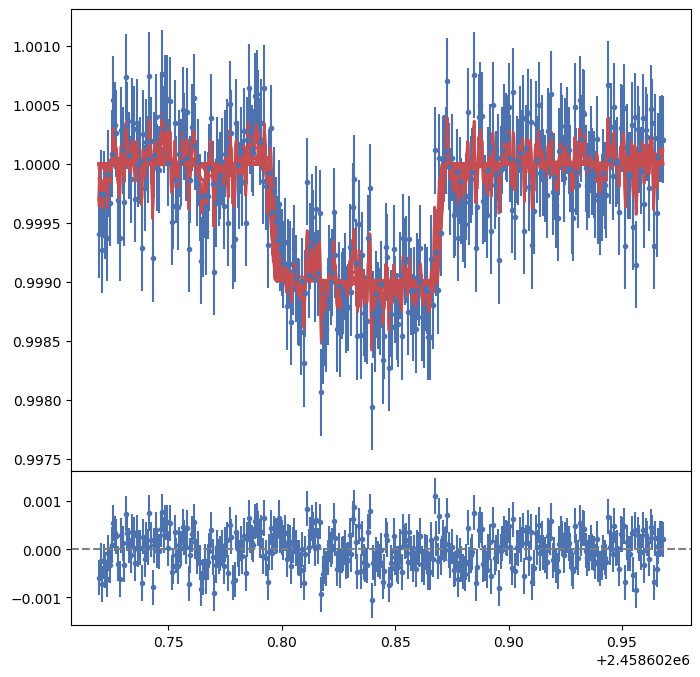

In [44]:
#::: settings
inst = 'spitzer'
key = 'flux'

#::: load the time, flux, and flux_err
time = af.data[inst]['time']
flux = af.data[inst][key]
flux_err = af.data[inst]['err_scales_'+key] * af.posterior_params_median['err_'+key+'_'+inst]

#::: set up the figure
fig, axes = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

#::: top panel: plot the data and 20 curves from random posterior samples (evaluated on a fine time grid)
ax = axes[0]
ax.errorbar(time, flux, flux_err, fmt='b.')
for i in range(20):
    time_fine = np.linspace(time[0], time[-1], 1000)
    model_fine, baseline_fine, _ = af.get_one_posterior_curve_set(inst, key, xx=time_fine)
    #ax.plot(time_fine, 1.+baseline_fine, 'g-', lw=2)
    ax.plot(time_fine, model_fine+baseline_fine, 'r-', lw=2)

#::: bottom panel: plot the residuals;
#::: for that, subtract the "posterior median model" and "posterior median baseline" from the data (evaluated on the time stamps of the data)
ax = axes[1]
baseline = af.get_posterior_median_baseline(inst, key)
model = af.get_posterior_median_model(inst, key)
ax.errorbar(time, flux-(model+baseline), flux_err, fmt='b.')
ax.axhline(0, color='grey', linestyle='--')

## API
https://www.allesfitter.com/api